In [1]:
import glob
import os
from typing import List, Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [2]:
config = {
    "data_folder": "../data/products/",
    "output_folder": "../output/",
}

In [3]:
def get_product_names():
    """Get the product names from the folders in the data folder."""
    folders = glob.glob(config["data_folder"] + "*/")
    product_names = [
        (folder, " ".join(folder.rstrip("/").split("_")[1:])) for folder in folders
    ]
    return product_names

In [4]:
products = get_product_names()
print(products)

[('../data/products/03_bead_bracelets_and_necklaces/', 'bead bracelets and necklaces'), ('../data/products/08_chinese_mid_autumn_gift_sets/', 'chinese mid autumn gift sets'), ('../data/products/12_chinese_pottery/', 'chinese pottery'), ('../data/products/07_chinese_incense/', 'chinese incense'), ('../data/products/13_chinese_magnets/', 'chinese magnets'), ('../data/products/04_paper_lanterns/', 'paper lanterns'), ('../data/products/06_chinese_bamboo_art/', 'chinese bamboo art'), ('../data/products/11_chinese_washi_tape/', 'chinese washi tape'), ('../data/products/10_chinese_art_stickers/', 'chinese art stickers'), ('../data/products/05_brushes_and_calligraphy_tools/', 'brushes and calligraphy tools'), ('../data/products/01_calligraphy_prints/', 'calligraphy prints'), ('../data/products/09_chinese_bookmarks/', 'chinese bookmarks'), ('../data/products/02_name_seals/', 'name seals')]


In [7]:
def get_search_term_from_file_name(file_name: str) -> str:
    """Get the search term from the file name."""
    return file_name.replace("_product_detail.csv", "").replace("_", " ")


def get_product_data(data_folder: str, product_name: str) -> pd.DataFrame:
    """Get the data for a product, loaded into a Polars DataFrame."""
    files = glob.glob(data_folder + "/*.csv")
    dataframes = []
    for file in files:
        df = pd.read_csv(file)
        # Add the search term and product name to the dataframe
        df["search_term"] = get_search_term_from_file_name(os.path.basename(file))
        df["product_name"] = product_name
        df["Tags"] = df["Tags"].apply(lambda x: x.split(","))
        df['Price("$")'] = df['Price("$")'].astype(str)
        df["price"] = df['Price("$")'].str.replace(",", "").astype(float)
        dataframes.append(df)

    # Concatenate the dataframes
    joined_df = pd.concat(dataframes)
    return joined_df


def filter_has_sales(df: pd.DataFrame) -> pd.DataFrame:
    """Filter the dataframe to only include rows that have sales."""
    return df[df["Total Sales"] > 0]


def get_all_product_data(products: List[str]) -> pd.DataFrame:
    """Get all the product data for a list of products."""
    dataframes = []
    for product in products:
        dataframes.append(
            get_product_data(product[0], product[1]).pipe(filter_has_sales)
        )
    return pd.concat(dataframes)

In [8]:
all_product_data = get_all_product_data(products)

In [9]:
all_product_data

,Title,Category,"Price(""$"")",7-day sales,Total Sales,Total Reviews,7-day Reviews,Total Favorites,7-day Favorites,Tags,...,Release Time,Best Seller,Etsy Pick,Raving,Store Name,Product URL,Image URL,search_term,product_name,price
1,"Green/Pink Bangle set, 22k Gold Plated, White ...",Jewelry > Bracelets > Bangles,59.0,0,7,0,0,16,0,"[Bangles Set, Indian Bangles, Traditional Bang...",...,2020-02-07,False,False,False,NemaliJewelry,https://www.etsy.com/listing/762738828/greenpi...,Upgrade Pro to Unlock,traditional stone bead jewelry,bead bracelets and necklaces,59.00
3,Seed Bead Stitching - Creative Variations On T...,Craft Supplies & Tools,8.75,0,5,0,0,4,0,"[Beading Book, Beaded Necklace, Making Jewelry...",...,2021-06-20,False,False,False,NeedANeedle,https://www.etsy.com/listing/1024845656/seed-b...,Upgrade Pro to Unlock,traditional stone bead jewelry,bead bracelets and necklaces,8.75
12,Natural Amethyst Tyre Shape Gemstone Beads 4-6...,Craft Supplies & Tools,0.72,0,1,0,0,0,0,"[Craft Supplies & Tools, Beads, Gems & Caboch...",...,NaN,False,False,False,SBGEMSInd,https://www.etsy.com/listing/1350542675/natura...,Upgrade Pro to Unlock,traditional stone bead jewelry,bead bracelets and necklaces,0.72
13,"Handmade Unisex African Bracelet, African gems...",Jewelry > Bracelets > Beaded Bracelets,17.09,0,5,0,0,0,0,"[Jewelry, Bracelets, Beaded Bracelets, matte o...",...,2018-02-05,False,False,False,Andyscollection,https://www.etsy.com/listing/577705094/handmad...,Upgrade Pro to Unlock,traditional stone bead jewelry,bead bracelets and necklaces,17.09
14,Vintage Multilayer Genuine Leather Men Bracele...,Weddings > Jewelry > Bracelets,27.19,0,5,0,0,13,0,"[Weddings, Jewelry, Bracelets, leather, vintag...",...,NaN,False,False,False,ShaanFashionz,https://www.etsy.com/listing/1234169822/vintag...,Upgrade Pro to Unlock,traditional stone bead jewelry,bead bracelets and necklaces,27.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,Custom Name Seal/Stone Seal Carving/Chinese St...,Craft Supplies & Tools,29.99,0,142,22,0,428,0,"[Square Seal, Stone Stamp, Chinese Chop, Name ...",...,2021-07-25,False,False,False,SemliCalligraphy,https://www.etsy.com/listing/818384039/custom-...,Upgrade Pro to Unlock,chinese name stamps,name seals,29.99
209,Custom Japanese name seal stamp/HANKO KANJI/Ha...,Craft Supplies & Tools,22.5,0,194,52,0,728,1,"[Stamp, Birthday, Made to Order, Name Seal, Cu...",...,2020-01-19,False,False,False,1000dou,https://www.etsy.com/listing/738772594/custom-...,Upgrade Pro to Unlock,chinese name stamps,name seals,22.50
210,"Chinese zodiac Seal, Personal Name Stamp,Custo...",Craft Supplies & Tools,32.99,0,4,0,0,41,0,"[Chinese Seal, Chinese Seal Custom, Name Seal,...",...,NaN,False,False,False,SealCuttingArts,https://www.etsy.com/listing/1016675563/chines...,Upgrade Pro to Unlock,chinese name stamps,name seals,32.99
211,Personal Name Seal Carved Stone Stamp Calligra...,Craft Supplies & Tools,28.99,0,3,0,0,16,0,"[Chinese Seal, Personalized Seal, Chinese Stam...",...,NaN,False,False,False,SemliCalligraphy,https://www.etsy.com/listing/734223139/persona...,Upgrade Pro to Unlock,chinese name stamps,name seals,28.99


In [11]:
# Output the data to a CSV file
all_product_data.to_csv(config["output_folder"] + "all_product_data.csv", index=False)

In [45]:
def format_col_for_title(col: str) -> str:
    """Format a column name for a title."""
    return " ".join(col.split("_")).title()


def plot_violin(data, x, y, remove_outliers=False):
    fig, ax = plt.subplots()

    if remove_outliers:
        # Calculate the 1st and 3rd quartiles
        q1 = data[x].quantile(0.25)
        q3 = data[x].quantile(0.75)

        # Calculate the interquartile range (IQR)
        iqr = q3 - q1

        # Define the lower and upper bounds for outliers
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Filter the data to remove outliers
        data = data[(data[x] >= lower_bound) & (data[x] <= upper_bound)]

    seaborn.violinplot(data=data, x=x, y=y, orient="h", ax=ax, cut=0)
    x_label = format_col_for_title(x)
    y_label = format_col_for_title(y)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f"Violin Plot of {x_label} by {y_label}")
    plt.show()

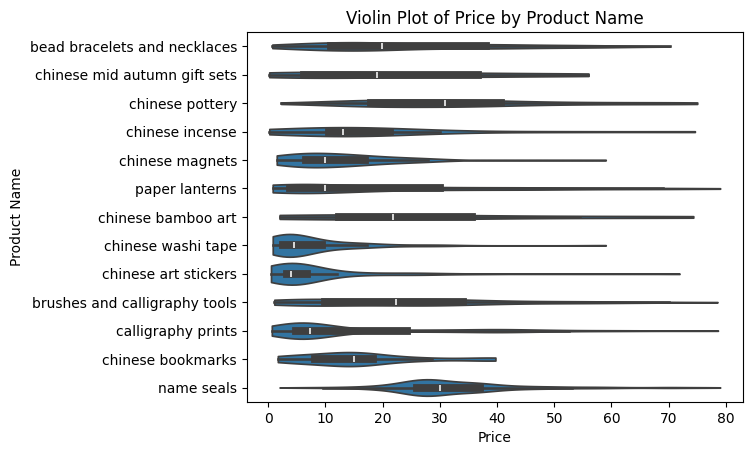

In [46]:
plot_violin(all_product_data, "price", "product_name", remove_outliers=True)

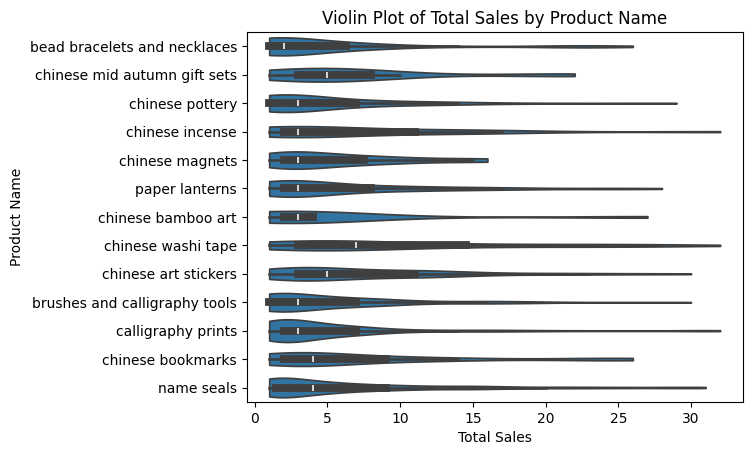

In [47]:
plot_violin(all_product_data, "Total Sales", "product_name", remove_outliers=True)